**Packages**

In [1]:
import re
import numpy as np
import seaborn as sns
import spacy

In [2]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


In [3]:
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import imp

tools = imp.load_source('tools', './lda_tools.py')

C:\Users\kleinow\AppData\Local\Temp\ipykernel_17356\640310604.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


**The data set**

In [5]:
import pandas as pd

In [6]:
df = pd.read_csv('./cn_items_clean.csv')

In [7]:
df.head()

,item_id,fk_repository_history,pubyear,pubmonth,wos_pubdate_online,item_title,scopus_item_title_non_eng,first_author,doi,pmid,...,fncr_5_years,fncr_all_years,hc_3_years,hc_5_years,hc_all_years,oa_status,oa_url,scopus_oa_licence,abstract,title_lower
0,WOS:000173024600148,19474708,2001,NaN,NaN,Extracting slow subspaces from natural videos ...,NaN,"Kayser, C",NaN,NaN,...,2.503746,0.916440,"{""(\""Computer Science, Artificial Intelligence...","{""(\""Computer Science, Artificial Intelligence...","{""(\""Computer Science, Artificial Intelligence...",NaN,NaN,NaN,"{""Natural videos obtained from a camera mounte...",extracting slow subspaces from natural videos ...
1,WOS:000225749600004,25952386,2004,11.0,NaN,Models of the subthalamic nucleus - The import...,NaN,"Gillies, A",10.1016/j.medengphy.2004.06.003,15564109.0,...,0.616486,0.683756,"{""(\""Engineering, Biomedical\"",0.0)""}","{""(\""Engineering, Biomedical\"",0.0)""}","{""(\""Engineering, Biomedical\"",0.0)""}",NaN,NaN,NaN,"{""A coherent set of models is presented that p...",models of the subthalamic nucleus - the import...
2,WOS:000225975400002,52560831,2005,1.0,NaN,Synaptic and spiking dynamics underlying rewar...,NaN,"Deco, G",10.1093/cercor/bhh103,15238449.0,...,2.263256,1.119644,"{""(Neurosciences,1.0)""}","{""(Neurosciences,1.0)""}","{""(Neurosciences,0.0)""}","{green_submitted,bronze}",NaN,NaN,"{""Cognitive and emotional flexibility involve ...",synaptic and spiking dynamics underlying rewar...
3,WOS:000232166100016,51224037,2005,9.0,NaN,Rapid reshaping of human motor generalization,NaN,"Thoroughman, KA",10.1523/jneurosci.1771-05.2005,16192385.0,...,0.856367,1.360798,"{""(Neurosciences,0.0)""}","{""(Neurosciences,0.0)""}","{""(Neurosciences,0.0)""}","{green_published,bronze,green_submitted}",NaN,NaN,"{""People routinely learn how to manipulate new...",rapid reshaping of human motor generalization
4,WOS:000236717500009,5616690,2006,4.0,NaN,Some insights into computational models of (pa...,NaN,"Suffczynski, P",10.1109/jproc.2006.871773,NaN,...,0.305249,0.229523,"{""(\""Engineering, Electrical & Electronic\"",0....","{""(\""Engineering, Electrical & Electronic\"",0....","{""(\""Engineering, Electrical & Electronic\"",0....",{green_submitted},NaN,NaN,"{""The amount of experimental data concerning p...",some insights into computational models of (pa...


In [8]:
#extra = pd.read_csv('../data/new_auction_data.csv', index_col=0)
# Abstracts are already part of my data set

In [9]:
#df = pd.concat([df, extra]) # No need to concat here because abstracts are already part of my data set

In [10]:
data = df[['abstract', 'item_id', 'title_lower', 'pubyear']]

In [11]:
data = data.drop_duplicates() # Should ot change anything since dataset is already cleaned

In [12]:
data = data.reset_index(drop=True)

In [13]:
#Add another column with combined title and abstract
data['title_abs'] = data['title_lower'] + " " + data['abstract']
data['title_abs'] = data['title_abs'].str.replace("{", "").str.replace("}", "") # Remove curly brackets

In [14]:
#pd.set_option('display.max_colwidth', None)

data.head()

,abstract,item_id,title_lower,pubyear,title_abs
0,"{""Natural videos obtained from a camera mounte...",WOS:000173024600148,extracting slow subspaces from natural videos ...,2001,extracting slow subspaces from natural videos ...
1,"{""A coherent set of models is presented that p...",WOS:000225749600004,models of the subthalamic nucleus - the import...,2004,models of the subthalamic nucleus - the import...
2,"{""Cognitive and emotional flexibility involve ...",WOS:000225975400002,synaptic and spiking dynamics underlying rewar...,2005,synaptic and spiking dynamics underlying rewar...
3,"{""People routinely learn how to manipulate new...",WOS:000232166100016,rapid reshaping of human motor generalization,2005,rapid reshaping of human motor generalization ...
4,"{""The amount of experimental data concerning p...",WOS:000236717500009,some insights into computational models of (pa...,2006,some insights into computational models of (pa...


In [15]:
data.describe() # what is the ref published in 1000?

,pubyear
count,1553.000000
mean,2014.189955
std,6.562691
min,1991.000000
25%,2010.000000
50%,2016.000000
75%,2019.000000
max,2023.000000


**Sentences to words**

In [16]:
#data['title_lower'] = data['title_lower'].astype(str)

In [17]:
words = list(tools.sentences_to_words(data['title_abs'].values))

In [18]:
# Check if format turned out as expected
print(words[:5])

[['extracting', 'slow', 'subspaces', 'from', 'natural', 'videos', 'leads', 'to', 'complex', 'cells', 'natural', 'videos', 'obtained', 'from', 'camera', 'mounted', 'on', 'cat', 'head', 'axe', 'used', 'as', 'stimuli', 'for', 'network', 'of', 'subspace', 'energy', 'detectors', 'the', 'network', 'is', 'trained', 'by', 'gradient', 'ascent', 'on', 'an', 'objective', 'function', 'defined', 'by', 'the', 'squared', 'temporal', 'derivatives', 'of', 'the', 'cells', 'outputs', 'the', 'resulting', 'receptive', 'fields', 'are', 'invariant', 'to', 'both', 'contrast', 'polarity', 'and', 'translation', 'and', 'thus', 'resemble', 'complex', 'type', 'receptive', 'fields'], ['models', 'of', 'the', 'subthalamic', 'nucleus', 'the', 'importance', 'of', 'intranuclear', 'connectivity', 'coherent', 'set', 'of', 'models', 'is', 'presented', 'that', 'provide', 'novel', 'and', 'testable', 'predictions', 'about', 'the', 'functional', 'role', 'of', 'the', 'subthalamic', 'nucleus', 'stn', 'in', 'the', 'basal', 'gangl

In [19]:
for word_list in words:
    for word in word_list:
        if isinstance(word, int):
            print("Found an integer:", word) # No, all good.

**Cleaning data set**

In [20]:
from nltk.corpus import stopwords
#import nltk
#nltk.download('stopwords')

In [21]:
stop_words = stopwords.words('english')

In [22]:
#print(stop_words)

In [23]:
# Build the bigram and trigram models
# N-grams are just continuos sequences of words
bigram = gensim.models.Phrases(words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [24]:
# lemmatized_words = tools.clean_words(words, bigram, stop_words) # old NG version
lemmatized_words = tools.clean_words(words, stop_words, bigram) # Order had to be changed because of the way the function is written

In [25]:
len(lemmatized_words) # 1553

1553

In [26]:
len(words) # Same, but also in NG version stays the same

1553

In [27]:
print(lemmatized_words[:5]) # looks fine, no flexion of words

[['extract', 'slow', 'subspace', 'natural', 'video', 'lead', 'complex', 'cell', 'natural', 'video', 'obtain', 'camera', 'mount', 'cat', 'head', 'axe', 'use', 'detector', 'network', 'train', 'gradient', 'ascent', 'objective', 'function', 'define', 'squared', 'temporal', 'derivative', 'cell', 'output', 'result', 'receptive', 'field', 'invariant', 'contrast', 'polarity', 'translation', 'thus', 'resemble', 'complex', 'type', 'receptive', 'field'], ['model', 'subthalamic', 'importance', 'intranuclear', 'connectivity', 'coherent', 'set', 'model', 'present', 'provide', 'novel', 'testable', 'prediction', 'functional', 'role', 'subthalamic', 'nucleus', 'stn', 'basal', 'ganglia', 'stn', 'emerge', 'important', 'target', 'novel', 'therapeutic', 'strategy', 'alleviation', 'parkinsonian', 'type', 'symptom', 'computational', 'mathematical', 'model', 'base', 'property', 'stn', 'interaction', 'review', 'model', 'focus', 'core', 'anatomical', 'physiological', 'datum', 'span', 'many', 'level', 'assess', 

**Create corpus**

In [28]:
id2word = corpora.Dictionary(lemmatized_words)

texts = lemmatized_words

corpus = [id2word.doc2bow(text) for text in texts]

**Create model and select number of topics**

In [29]:
#mallet_path = '/Users/storm/rsc/mallet-2.0.8/bin/mallet' # ?????

In [30]:
limit = 30 #9 # Adjust according to stabilization of coherence score

In [31]:
#print(gensim.__version__)

In [32]:
#!pip install gensim==3.8.3

In [33]:
# from gensim.models.wrappers import LdaMallet
# Switching to native LDA implementation

In [34]:
from gensim.models import LdaModel, CoherenceModel

In [35]:
def compute_coherence_values_gensim(dictionary, corpus, texts, limit, start=2, step=2): # Needed to be rewritten
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence="c_v")
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [36]:
#model_list, coherence_values = compute_coherence_values_gensim(id2word, corpus, lemmatized_words, limit=limit, start=2, step=1) # takes about 10 minutes

In [37]:
# Old version, needs mallet
# model_list, coherence_values = tools.compute_coherence_values(limit=limit,
#                                                              step=1,
#                                                              mallet_path=mallet_path,
#                                                              dictionary=id2word,
#                                                              corpus=corpus,
#                                                              texts=lemmatized_words)

#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.serif'] = 'Computer Modern Roman'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

fig = plt.subplots()

num_of_topics = range(2, limit, 1) # Start with two at least, makes no sense otherwise
plt.plot(num_of_topics, coherence_values, '-o')

plt.xlabel("Num Topics")
plt.ylabel("Coherence score");

for num, cv in zip(num_of_topics, coherence_values):
    print("Num Topics =", num, " has Coherence Value of", round(cv, 4)) # 4 for 4 digits

max_coherence_value = max(coherence_values)
max_index = coherence_values.index(max_coherence_value) # the number of topics will be where there is the highest coherence value

num_of_topics[max_index]

Find the averaged optimal number of topics

In [38]:
# Redefine compute_coherence_values_gensim to be able to pass different seeds
def compute_coherence_values_gensim_seed(dictionary, corpus, texts, limit, start=2, step=2, seed=0): 
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=seed, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence="c_v")
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [39]:
# set parameters:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  # Define seeds to be used # Lessen if too slow
all_coherence_values = [] # For list of lists of coherence values
start = 2
step = 1

In [40]:
seeds

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Attention, the next step is taking ages to run! Outcommented since this step has been done and I am just importing the results.

In [41]:
#for seed in seeds: # function compute_coherence_values_gensim is called with the current seed value
#    _, coherence_values = compute_coherence_values_gensim_seed(id2word, corpus, lemmatized_words, limit, start, step, seed)
#    #_ is a placeholder for model_list, which is not needed here
#    all_coherence_values.append(coherence_values)

In [42]:
#data_seeds = []
#for i, num_topics in enumerate(range(start, limit, step)):
#    for seed_index, seed in enumerate(seeds):
#        data_seeds.append({
#            'Number of Topics': num_topics,
#            'Coherence Value': all_coherence_values[seed_index][i],
#            'Seed': seed
#        })

In [43]:
#df_seeds = pd.DataFrame(data_seeds)

In [44]:
#df_seeds.to_csv("df_lda_seeds.csv", index=False) # So I don't have to run it again everytime

In [45]:
# Activate if the script needs to run but no time to wait for it to run through all seeds
df_seeds = pd.read_csv("df_lda_seeds.csv")

c:\Users\kleinow\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kleinow\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kleinow\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


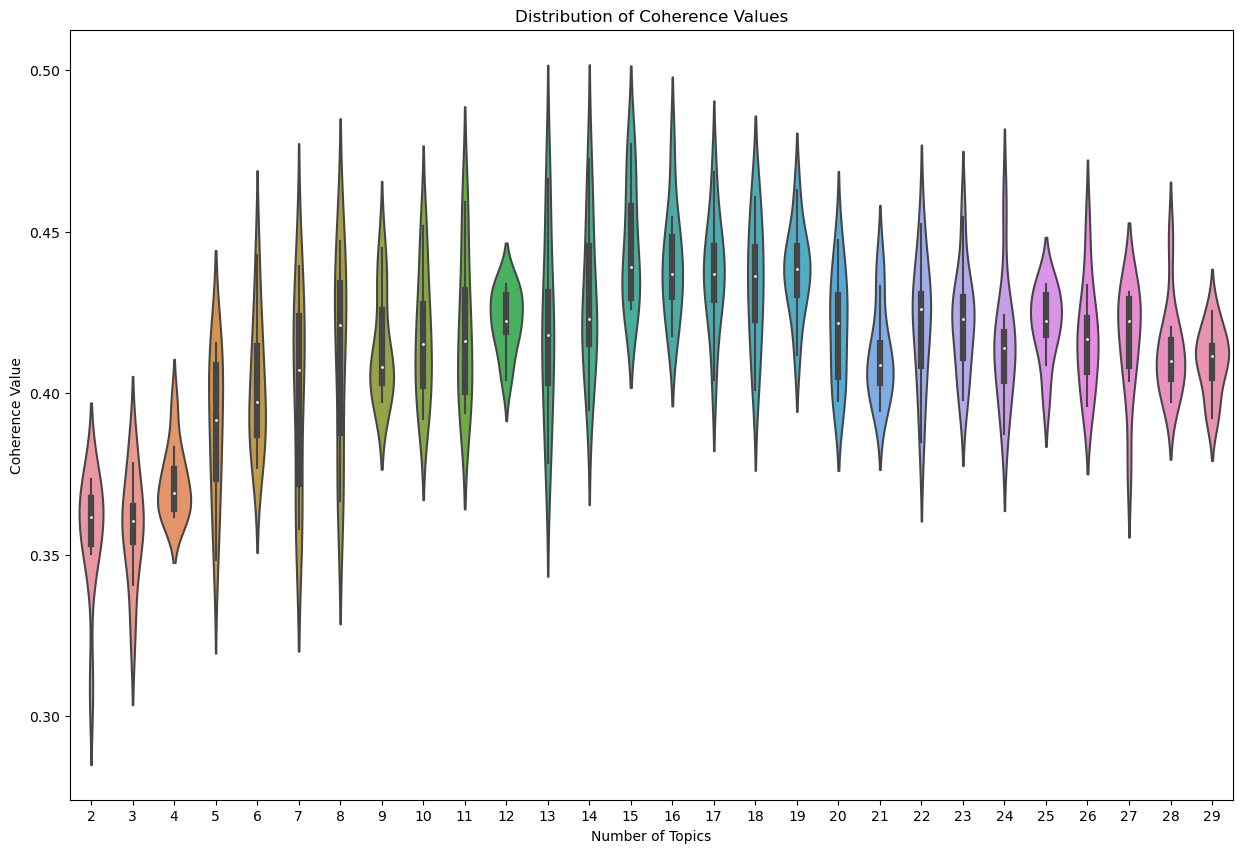

In [46]:
plt.figure(figsize=(15, 10))
sns.violinplot(x='Number of Topics', y='Coherence Value', data=df_seeds, fill=False)
#sns.swarmplot(x='Number of Topics', y='Coherence Value', data=df_seeds, color='k', alpha=0.5)
plt.title('Distribution of Coherence Values')
plt.show()

In [47]:
average_coherences = df_seeds.groupby('Number of Topics')['Coherence Value'].mean()


best_num_topics = average_coherences.idxmax()
highest_avg_coherence = average_coherences.max()
highest_avg_coherence # 0.44602461359382495
#best_num_topics # 15!!

0.44602461359382495

In [48]:
# Retrieve seed that produced the highest coherence score for 15 topics
df_8_topics = df_seeds[df_seeds['Number of Topics'] == 8]

best_seed = df_8_topics[df_8_topics['Coherence Value'] == df_8_topics['Coherence Value'].max()]['Seed'].values[0]
best_seed # 9


5

**Model for num topics = 8 with seed = 9**

In [49]:
# Adjust limit after having found the best number of topics
#limit = best_num_topics + 1
limit = 8 + 1

In [50]:
model_list, coherence_values = compute_coherence_values_gensim_seed(id2word, corpus, lemmatized_words, limit=limit, start=2, step=1, seed=best_seed) # takes about 10 minutes
# take care of the limit + 1 because range is exclusive!!!

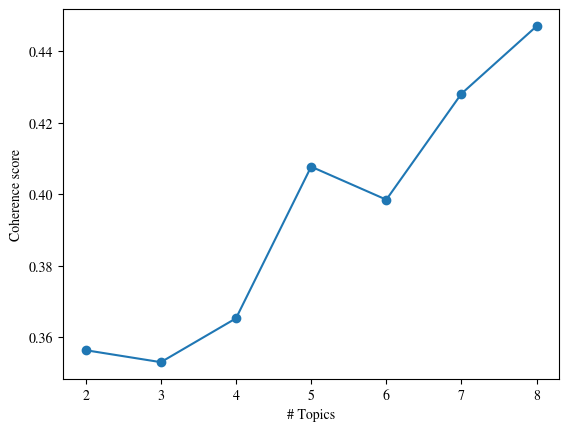

In [51]:
#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.serif'] = 'Computer Modern Roman'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

fig = plt.subplots()

num_of_topics = range(2, limit, 1) # Start with two at least, makes no sense otherwise
plt.plot(num_of_topics, coherence_values, '-o')

plt.xlabel("# Topics")
plt.ylabel("Coherence score");

In [52]:
for num, cv in zip(num_of_topics, coherence_values):
    print("Num Topics =", num, " has Coherence Value of", round(cv, 4)) # get this to a proper table

Num Topics = 2  has Coherence Value of 0.3564
Num Topics = 3  has Coherence Value of 0.3531
Num Topics = 4  has Coherence Value of 0.3653
Num Topics = 5  has Coherence Value of 0.4078
Num Topics = 6  has Coherence Value of 0.3985
Num Topics = 7  has Coherence Value of 0.4282
Num Topics = 8  has Coherence Value of 0.447


In [53]:
max_coherence_value = max(coherence_values)
max_index = coherence_values.index(max_coherence_value) 

In [54]:
num_of_topics[max_index]

8

In [55]:
optimal_model = model_list[max_index]
model_topics = optimal_model.show_topics(formatted=False)

In [56]:
model_topics

[(0,
  [('disorder', 0.03491887),
   ('psychiatry', 0.026610674),
   ('pipeline', 0.023760648),
   ('decomposition', 0.021746274),
   ('tensor', 0.019848047),
   ('mental', 0.018920653),
   ('coordination', 0.014266069),
   ('psychiatric', 0.01349132),
   ('substantial', 0.011768592),
   ('advanced', 0.0111957565)]),
 (1,
  [('brain', 0.03191794),
   ('datum', 0.018811379),
   ('neuroscience', 0.016665788),
   ('computational', 0.013855568),
   ('tool', 0.013541499),
   ('research', 0.013496948),
   ('use', 0.012933367),
   ('new', 0.010309112),
   ('development', 0.009509089),
   ('analysis', 0.009475887)]),
 (2,
  [('potential', 0.03228379),
   ('temperature', 0.025951019),
   ('extracellular', 0.018643362),
   ('membrane', 0.017110553),
   ('nerve', 0.015921682),
   ('case', 0.013092657),
   ('current', 0.013063708),
   ('intracellular', 0.011897101),
   ('cable', 0.0114784725),
   ('flow', 0.011265654)]),
 (3,
  [('network', 0.041285947),
   ('model', 0.028918985),
   ('neural', 0.

**Assign Documents to Topic**

def format_topics_sentences(ldamodel, corpus, data_frame):
    data_with_topics = pd.DataFrame(columns= ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']) # df has to be defined here already

    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)  # Adjusting this line to account for Gensim's output structure
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                # Change the appending line
                data_with_topics.loc[i] = [int(topic_num), round(prop_topic, 4), topic_keywords]
            else:
                break

    

    data_with_topics = pd.concat([data_with_topics, data_frame.reset_index(drop=True)], axis=1)
    return data_with_topics

In [57]:
# Rewritten function: Removed internal for loop; max() function to directly get the dominant topic for each row;
# topic data in a list and later converted to a dataframe, seems to be more efficient than appending rows after rows

def format_topics_sentences(ldamodel, corpus, data_frame):
    topics_data = []

    for row in ldamodel[corpus]:
        topic_num, prop_topic = max(row[0], key=lambda x: x[1])
        topic_keywords = ", ".join([word for word, _ in ldamodel.show_topic(topic_num)])
        topics_data.append([int(topic_num), round(prop_topic, 4), topic_keywords])

    data_with_topics = pd.DataFrame(topics_data, columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])
    return pd.concat([data_with_topics, data_frame.reset_index(drop=True)], axis=1)

In [58]:
# written for LDA models produced by MALLET that returns a list of tuples where each tuple is (topic_num, proportion)
# native Gensim LDA model returns a different structure for topics
data_with_topics = format_topics_sentences(ldamodel=optimal_model,
                                           corpus=corpus,
                                           data_frame=data)

In [59]:
data_with_topics.head()


,Dominant_Topic,Perc_Contribution,Topic_Keywords,abstract,item_id,title_lower,pubyear,title_abs
0,4,0.3584,"model, spike, neuron, dynamic, activity, signa...","{""Natural videos obtained from a camera mounte...",WOS:000173024600148,extracting slow subspaces from natural videos ...,2001,extracting slow subspaces from natural videos ...
1,6,0.4021,"computational, model, neuroscience, learn, sys...","{""A coherent set of models is presented that p...",WOS:000225749600004,models of the subthalamic nucleus - the import...,2004,models of the subthalamic nucleus - the import...
2,4,0.5725,"model, spike, neuron, dynamic, activity, signa...","{""Cognitive and emotional flexibility involve ...",WOS:000225975400002,synaptic and spiking dynamics underlying rewar...,2005,synaptic and spiking dynamics underlying rewar...
3,6,0.6123,"computational, model, neuroscience, learn, sys...","{""People routinely learn how to manipulate new...",WOS:000232166100016,rapid reshaping of human motor generalization,2005,rapid reshaping of human motor generalization ...
4,6,0.4555,"computational, model, neuroscience, learn, sys...","{""The amount of experimental data concerning p...",WOS:000236717500009,some insights into computational models of (pa...,2006,some insights into computational models of (pa...


**Find the most representative document for each topic**

In [60]:
documents_of_topic = pd.DataFrame()

documents_of_topic_grpd = data_with_topics.groupby('Dominant_Topic')

for i, grp in documents_of_topic_grpd:
    documents_of_topic = pd.concat([documents_of_topic, 
                                    grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                    axis=0)
documents_of_topic.reset_index(drop=True, inplace=True)
documents_of_topic = documents_of_topic[['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords','title_lower', 'pubyear']]

In [61]:
documents_of_topic.values

array([[0, 0.3400999903678894,
        'disorder, psychiatry, pipeline, decomposition, tensor, mental, coordination, psychiatric, substantial, advanced',
        'seasonal variation in collective mood via twitter content and medical purchases',
        2017],
       [1, 0.6518999934196472,
        'brain, datum, neuroscience, computational, tool, research, use, new, development, analysis',
        'exploration and virtual experimentation in a local neuroscience database',
        1995],
       [2, 0.9261999726295471,
        'potential, temperature, extracellular, membrane, nerve, case, current, intracellular, cable, flow',
        'effects of temperature on simulated electrotonic potentials and their current kinetics of human motor axons at 20 degrees c-42 degrees c',
        2014],
       [3, 0.901199996471405,
        'network, model, neural, use, simulation, method, neuron, computational, large, datum',
        'gpu implementation of neural-network simulations based on adaptive-exp

In [62]:
from collections import defaultdict

def compute_document_topic_contribution(model, corpus):
    document_topic_contributions = []
    
    for index, doc in enumerate(corpus):
        total_topic_contrib = defaultdict(float)
        
        for word_id, word_count in doc:
            word_topics = model.get_term_topics(word_id, minimum_probability=0.001)  # Adjust minimum_probability if needed
            
            for topic, prob in word_topics:
                total_topic_contrib[topic] += prob * word_count

        # To handle potential ZeroDivisionError
        try:
            # Normalize the contribution to percentage
            total_contrib_percent = {topic: (contrib / sum(total_topic_contrib.values())) * 100 for topic, contrib in total_topic_contrib.items()}
            document_topic_contributions.append(total_contrib_percent)
        except ZeroDivisionError:
            print(f"Error for document at index {index}: No topic contributions found.")
            continue
            
    return document_topic_contributions

contributions = compute_document_topic_contribution(model, corpus)

# Creating a DataFrame to visualize
df_contributions = pd.DataFrame(contributions)
df_contributions["pubyear"] = data["pubyear"]

# Plotting
for topic in range(model.num_topics):
    plt.figure(figsize=(15, 7))
    sns.boxplot(data=df_contributions, x="pubyear", y=topic)
    plt.title(f"Topic {topic+1} Contribution Over the Years")
    plt.ylabel("Contribution (%)")
    plt.show()

NameError: name 'model' is not defined

**Stats summary for each topic**

In [63]:
topic_counts = data_with_topics['Dominant_Topic'].value_counts()

topic_contribution = round(topic_counts/topic_counts.sum(), 4)

In [64]:
stats= pd.DataFrame([topic_counts.index,
                     topic_counts,
                     topic_contribution]).T
stats.columns = ['Dominant_Topic', 'Num of Documents', 'Percentage of Documents']

In [65]:
stats

,Dominant_Topic,Num of Documents,Percentage of Documents
0,6.0,751.0,0.4836
1,4.0,384.0,0.2473
2,3.0,274.0,0.1764
3,1.0,106.0,0.0683
4,2.0,25.0,0.0161
5,7.0,8.0,0.0052
6,5.0,3.0,0.0019
7,0.0,2.0,0.0013


In [66]:
topic_num_keywords = data_with_topics[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates()

df_topics = pd.merge(stats, topic_num_keywords, on='Dominant_Topic')

In [67]:
df_topics['Topic_Keywords'].values

array(['computational, model, neuroscience, learn, system, brain, approach, cognitive, theory, control',
       'model, spike, neuron, dynamic, activity, signal, neural, use, synaptic, result',
       'network, model, neural, use, simulation, method, neuron, computational, large, datum',
       'brain, datum, neuroscience, computational, tool, research, use, new, development, analysis',
       'potential, temperature, extracellular, membrane, nerve, case, current, intracellular, cable, flow',
       'equation, cell, differential, density, excitatory, system, distance, solution, bifurcation, problem',
       'deficit, reward, mechanical, law, damage, dopaminergic, dopamine, fitting, unexpected, chemical',
       'disorder, psychiatry, pipeline, decomposition, tensor, mental, coordination, psychiatric, substantial, advanced'],
      dtype=object)

In [68]:
topic_num_keywords

,Dominant_Topic,Topic_Keywords
0,4,"model, spike, neuron, dynamic, activity, signa..."
1,6,"computational, model, neuroscience, learn, sys..."
7,2,"potential, temperature, extracellular, membran..."
9,3,"network, model, neural, use, simulation, metho..."
23,1,"brain, datum, neuroscience, computational, too..."
68,5,"deficit, reward, mechanical, law, damage, dopa..."
127,7,"equation, cell, differential, density, excitat..."
164,0,"disorder, psychiatry, pipeline, decomposition,..."


**Number of topics per year**

In [69]:
yearly = (
        data_with_topics.groupby(["Dominant_Topic", "pubyear"]).size().reset_index().groupby("pubyear").size()
    )

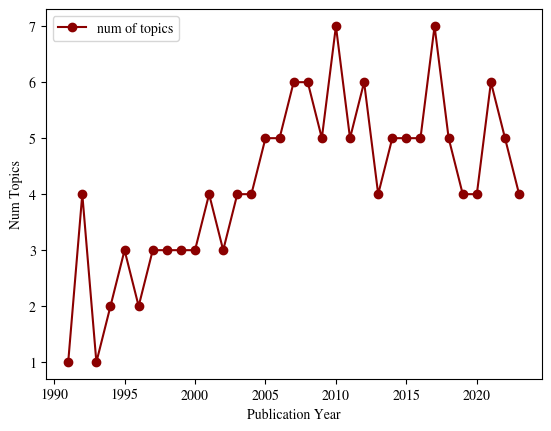

In [70]:
fig = plt.subplots()
plt.plot(yearly, '-o', color='darkred', label='num of topics');

plt.legend();
plt.ylabel("Num Topics")
plt.xlabel("Publication Year");

In [71]:
first_row = next(iter(model_list[0][corpus]))
print(first_row)

([(0, 0.55880487), (1, 0.4411951)], [(0, [0, 1]), (1, [0, 1]), (2, [1, 0]), (3, [0]), (4, [0, 1]), (5, [1, 0]), (6, [0, 1]), (7, [0, 1]), (8, [0]), (9, [0, 1]), (10, [0, 1]), (11, [1, 0]), (12, [0, 1]), (13, [0, 1]), (14, [0, 1]), (15, [1, 0]), (16, [0, 1]), (17, [1, 0]), (18, [0, 1]), (19, [1, 0]), (20, [0, 1]), (21, [0, 1]), (22, [0, 1]), (23, [1, 0]), (24, [1, 0]), (25, [0, 1]), (26, [0, 1]), (27, [0, 1]), (28, [0, 1]), (29, [0, 1]), (30, [0, 1]), (31, [0, 1]), (32, [0, 1]), (33, [1, 0]), (34, [0, 1]), (35, [0, 1]), (36, [1, 0])], [(0, [(0, 0.82295686), (1, 0.14098106)]), (1, [(0, 0.82295686), (1, 0.14098106)]), (2, [(0, 0.30454466), (1, 0.69058216)]), (3, [(0, 0.9922626)]), (4, [(0, 1.5313178), (1, 0.46858826)]), (5, [(0, 0.1891585), (1, 1.8106217)]), (6, [(0, 0.77743596), (1, 0.22242342)]), (7, [(0, 0.555622), (1, 0.4442277)]), (8, [(0, 0.99397326)]), (9, [(0, 0.8383148), (1, 0.1533185)]), (10, [(0, 0.5377041), (1, 0.46205547)]), (11, [(0, 0.8062627), (1, 1.1936442)]), (12, [(0, 0

In [73]:
def get_topic_contributions_for_year(model, corpus, data, topic_num=0):
    topic_contributions = []
    
    for i, row_lists in enumerate(model[corpus]):
        row = row_lists[0]  # Get the list of (topic number, topic probability) pairs
        for topic, prob in row:
            if topic == topic_num:
                topic_contributions.append((data.iloc[i]['pubyear'], prob))
                
    return topic_contributions

all_contributions = []
for model in model_list:
    all_contributions.extend(get_topic_contributions_for_year(model, corpus, data))

# Convert to DataFrame for easier plotting
df_contributions = pd.DataFrame(all_contributions, columns=['pubyear', 'contribution'])







In [74]:
# this plot will not be considered
#plt.figure(figsize=(15, 7))
#sns.violinplot(x="pubyear", y="contribution", data=df_contributions)
#plt.title("Influence of Topic 1 Over the Years")
#plt.show()

In [76]:
def get_normalized_topic_contributions_for_year(model, corpus, data, topic_num=0):
    yearly_contributions = {}
    
    for i, row_lists in enumerate(model[corpus]):
        year = data.iloc[i]['pubyear']
        row = row_lists[0]  # list of (topic number, topic probability) pairs
        
        for topic, prob in row:
            if topic == topic_num:
                if year not in yearly_contributions:
                    yearly_contributions[year] = {"total_prob": 0, "count": 0}
                
                yearly_contributions[year]["total_prob"] += prob
                yearly_contributions[year]["count"] += 1
                
    # average influence per document for each year
    avg_contributions = [(year, values["total_prob"] / values["count"]) for year, values in yearly_contributions.items()]
    
    return avg_contributions

all_contributions = []
for model in model_list:
    all_contributions.extend(get_normalized_topic_contributions_for_year(model, corpus, data))

# df for easier plotting
df_contributions = pd.DataFrame(all_contributions, columns=['pubyear', 'contribution'])



In [ ]:
#plt.figure(figsize=(15, 7))
#sns.violinplot(x="pubyear", y="contribution", data=df_contributions)
#plt.title("Influence of Topic 1 Over the Years")
#plt.show()

**Number of articles per topic per year**

In [ ]:
groups = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 
          '11', '12', '13', '14', '15']

In [ ]:
selected_num_topics = num_of_topics[max_index]

In [ ]:
table = data_with_topics.groupby(['pubyear', 'Dominant_Topic']).size()

In [ ]:
data_with_topics['Dominant_Topic'].unique()

array([4, 6, 2, 3, 1, 5, 7, 0], dtype=int64)

In [ ]:
table

pubyear  Dominant_Topic
1991     6                  2
1992     1                  1
         3                  1
         4                  1
         6                  2
                           ..
2022     7                  1
2023     1                  2
         3                  4
         4                  7
         6                 14
Length: 139, dtype: int64

In [ ]:
years = sorted(data_with_topics.pubyear.unique())

In [ ]:
counts = []
for year in years:
    specific_year = data_with_topics[data_with_topics['pubyear'] == year]
    count = []
    for topic in range(selected_num_topics):
        count.append(specific_year[specific_year["Dominant_Topic"] == topic].count().values[0])
    counts.append(count)

In [ ]:
#print(len(groups))
#print(max([len(c) for c in counts]))
#print(selected_num_topics)

In [ ]:
#fig = plt.subplots(figsize=(10, 7))
#loop_range = min(len(groups), min([len(c) for c in counts]))
#for i in range(loop_range):
#    plt.plot(years, [c[i] for c in counts], '-o', label=f"{groups[i]}")
#plt.legend();

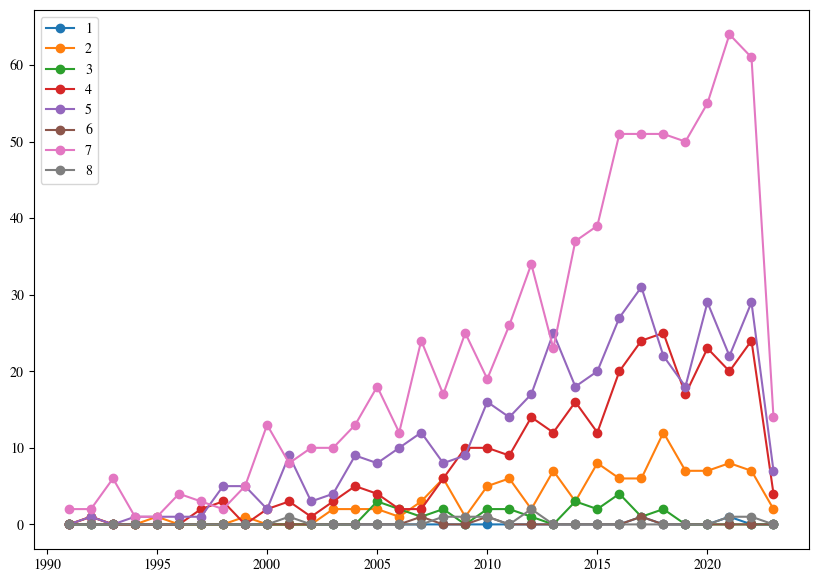

In [ ]:
fig = plt.subplots(figsize=(10, 7))
for i in range(selected_num_topics):
    plt.plot(years, [c[i] for c in counts], '-o', label=f"{groups[i]}");
plt.legend();

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


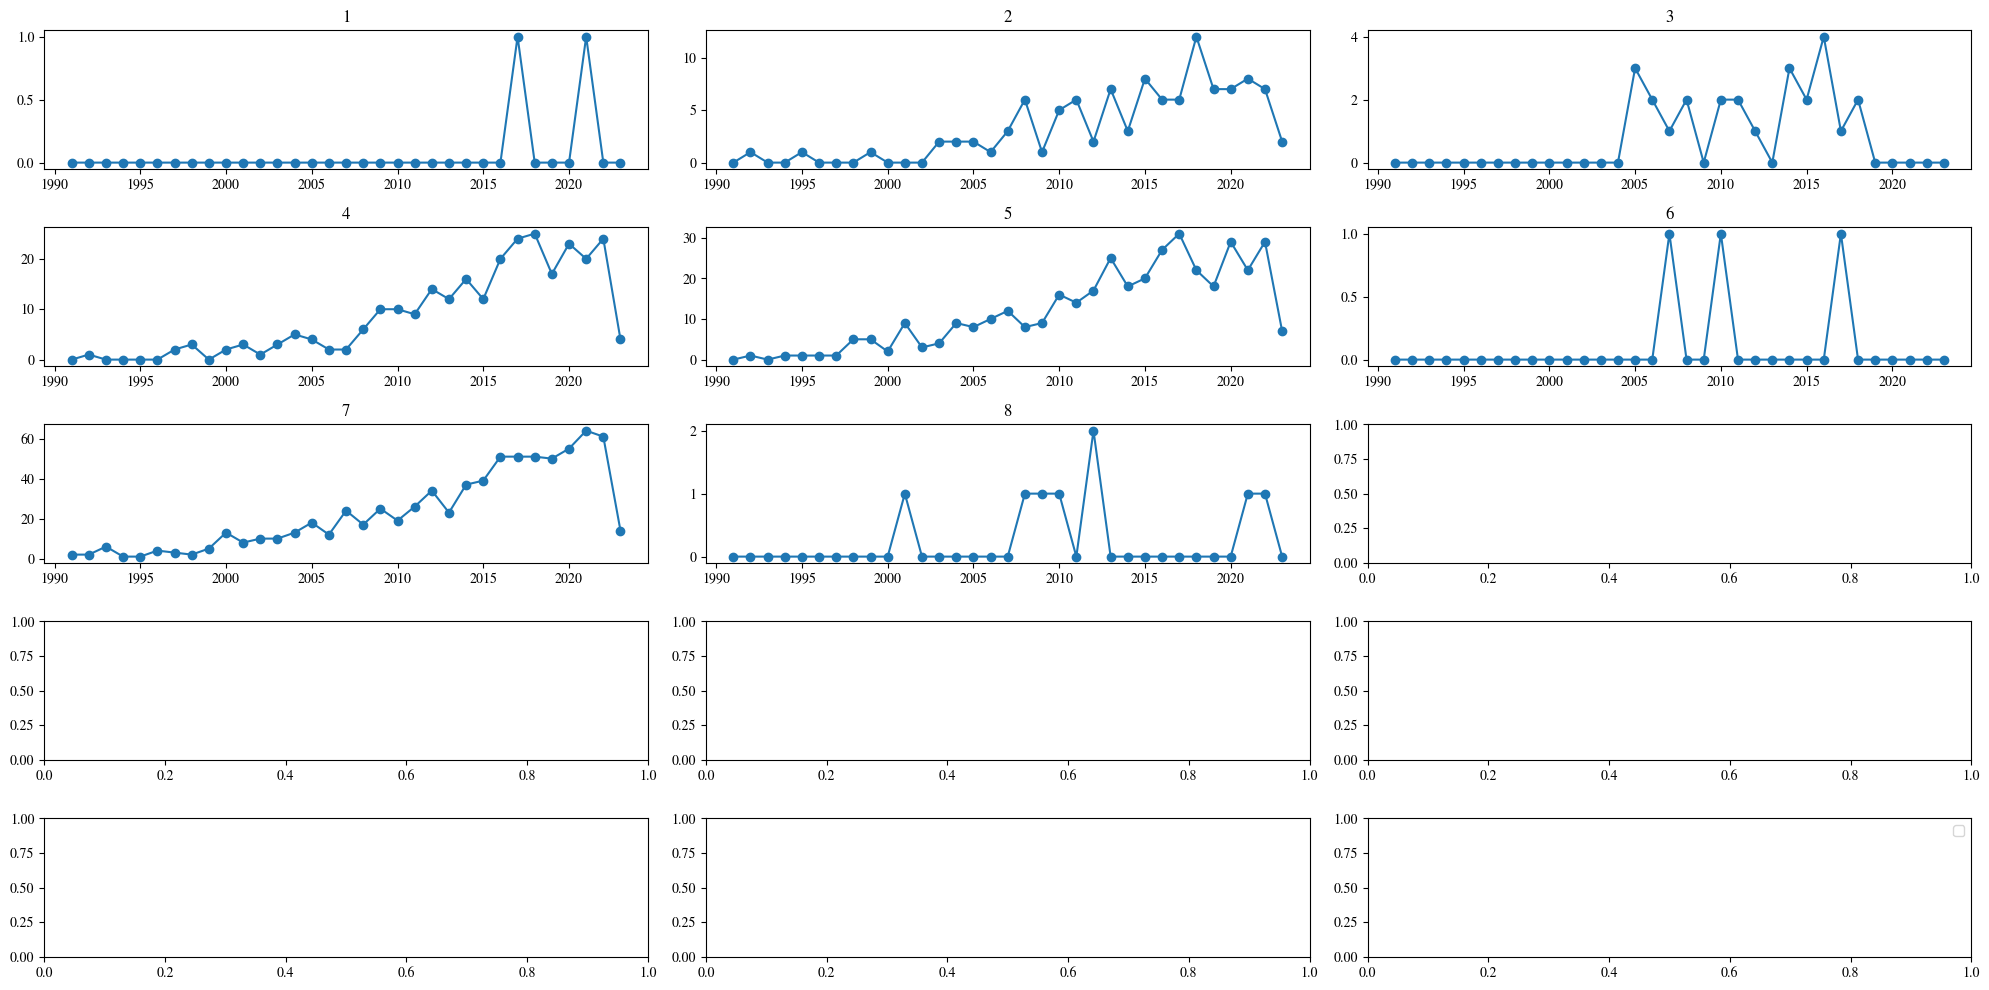

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 10)) # adjust according to number of topics
flat_axes = axes.flatten()

for i in range(selected_num_topics): # slightly changed in comparison to NG with flattened axes
    flat_axes[i].plot(years, [c[i] for c in counts], '-o')
    flat_axes[i].set_title(groups[i])
flat_axes[-1].legend() # fig.legend(loc='upper right') for legend in one place
plt.tight_layout() 
plt.show()

In [ ]:
subset_of_years = years[20:]

In [ ]:
counts = []
for year in subset_of_years:
    specific_year = data_with_topics[data_with_topics['pubyear'] == year]
    count = []
    for topic in range(selected_num_topics):
        count.append(specific_year[specific_year["Dominant_Topic"] == topic].count().values[0])
    counts.append(count)

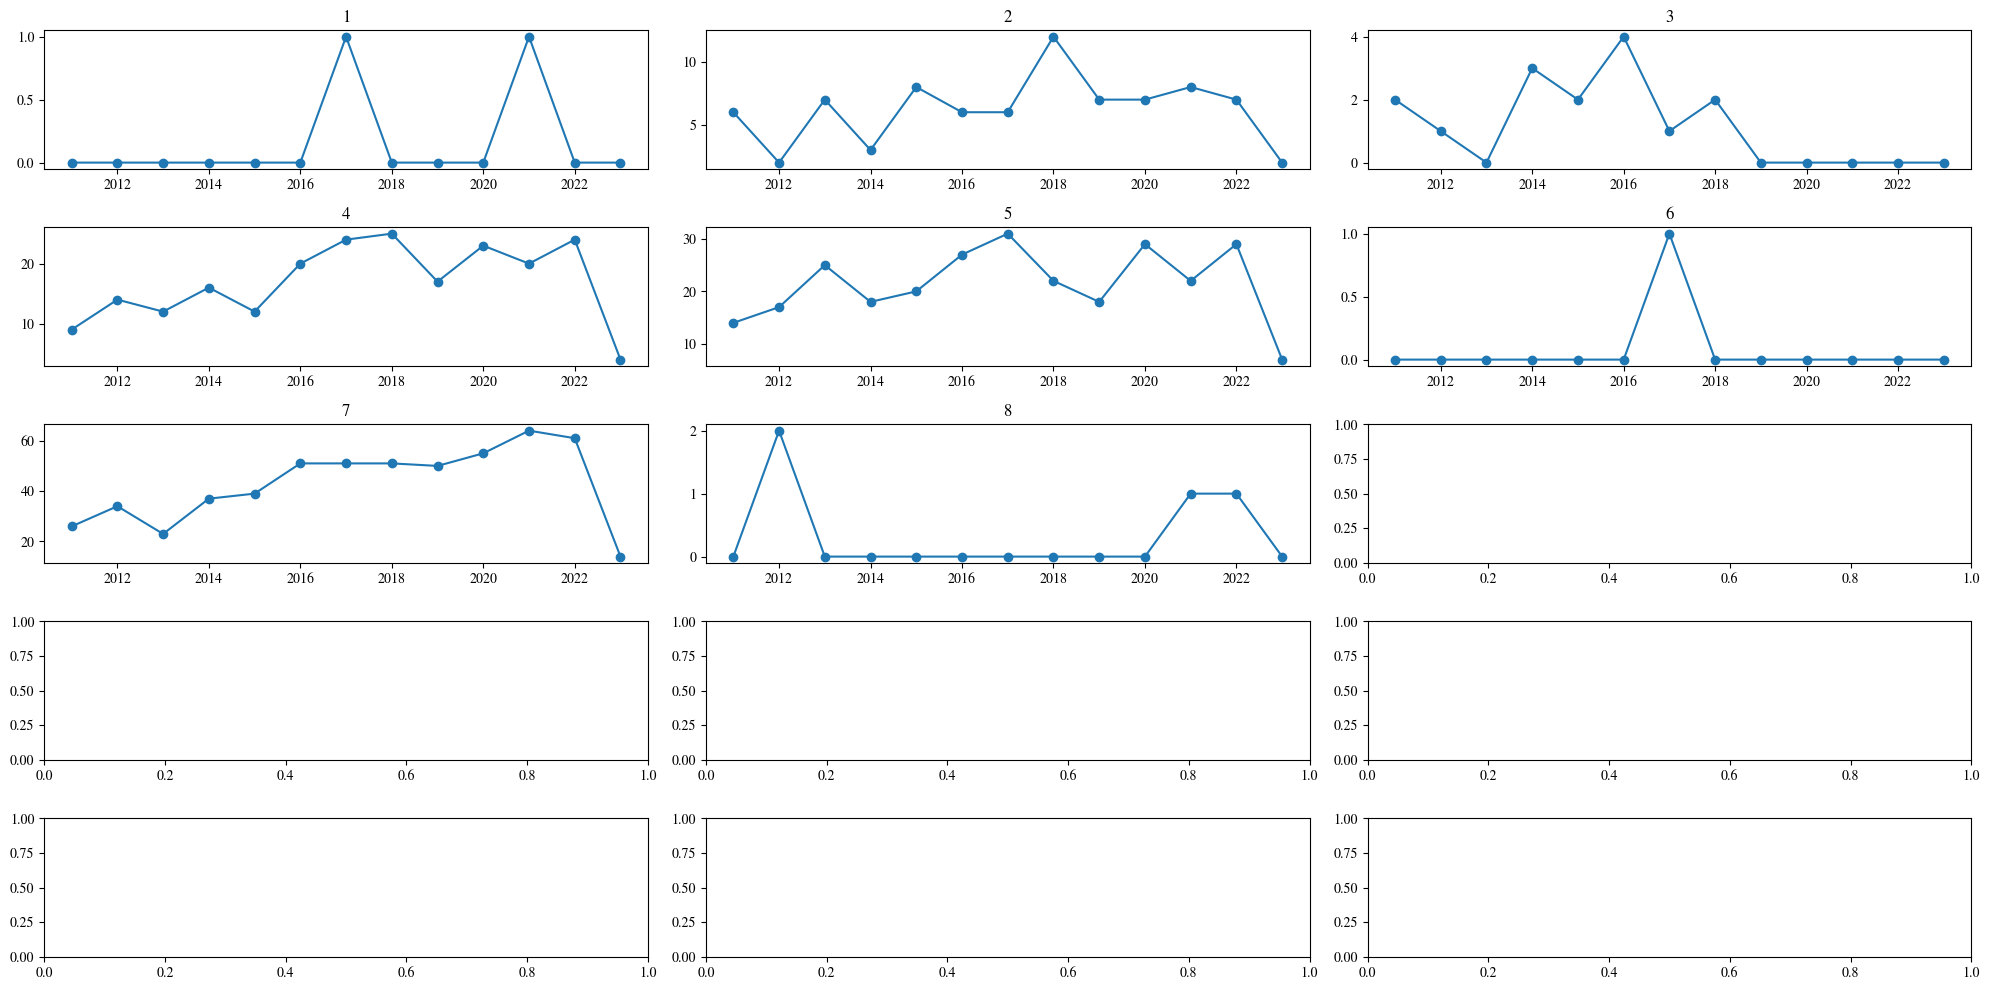

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 10))
for i in range(selected_num_topics):
    index = (int(i / 3), i % 3)
    axes[index].plot(subset_of_years, [c[i] for c in counts], '-o');
    axes[index].set_title(groups[i])
plt.tight_layout()

# for legends on last "real" plot
#if selected_num_topics < 24:
#    axes[int((selected_num_topics - 1) / 4), (selected_num_topics - 1) % 4].legend()

plt.show()

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_of_topics[max_index], 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.220348  0.079236       1        1  38.227486
5     -0.257656  0.025651       2        1  28.743882
3     -0.173616 -0.129874       3        1  14.315520
0      0.075125 -0.193741       4        1   5.704764
2      0.075028  0.315843       5        1   4.389615
4      0.090287 -0.094730       6        1   4.197270
1      0.192559 -0.055728       7        1   2.480855
7      0.218621  0.053342       8        1   1.940608, topic_info=          Term         Freq        Total Category  logprob  loglift
169      spike   818.000000   818.000000  Default  30.0000  30.0000
19     network  1691.000000  1691.000000  Default  29.0000  29.0000
240       time   687.000000   687.000000  Default  28.0000  28.0000
82       model  3449.000000  3449.000000  Default  27.0000  27.0000
1125    signal   545.000000   545.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
205   learning    48.610327   276.662047   Topic8  -4.2160   2.2032
207       make    28.744605   324.498210   Topic8  -4.7414   1.5183
1376   student    17.715928    28.856862   Topic8  -5.2254   3.4543
158    produce    22.300589   168.754088   Topic8  -4.9952   1.9183
165     reward    19.946698    79.765833   Topic8  -5.1068   2.5561

[455 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3448      5  0.965142  accelerate
1526      2  0.989814    accuracy
1751      6  0.991300     acquire
119       1  0.701484      action
119       4  0.104091      action
...     ...       ...         ...
177       1  0.724835        work
177       2  0.214589        work
177       3  0.057224        work
3254      5  0.979437    workflow
959       1  0.988124        year

[690 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 4, 1, 3, 5, 2, 8])